In [ ]:
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import os
from glob import glob
from sklearn import metrics
import numpy as np
import random
import seaborn as sns
from collections import defaultdict

**Race Confounded by Disease**

In [ ]:
#We will binarize race by grouping individuals as White or Non-White
#Input the results csv and this function will output 2 dataframes, one of white individuals and one of nonwhite individuals
def binarize_by_race(df):
  white_df = df[df['Race/Ethnicity'].str.contains('White')]
  nonwhite_df = df[~df['Race/Ethnicity'].str.contains('White')]
  return(white_df, nonwhite_df)

In [ ]:
#This function will output a biased dataset as specified by the bias variable
def create_disease_biased_test_set(white_df, nonwhite_df, bias, disease_label):
  prop1 = sum(white_df[disease_label]==0.0)/len(white_df)
  prop2 = sum(nonwhite_df[disease_label]==0.0)/len(nonwhite_df)
  if bias<= prop1:
    biased_white_df = pd.concat([white_df, white_df[white_df[disease_label]==0.0].sample(int((sum(white_df[disease_label]==0.0)-len(white_df)*bias)/(1-bias)), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  else:
    biased_white_df = pd.concat([white_df, white_df[white_df[disease_label]==1.0].sample(int((sum(white_df[disease_label]==1.0)-len(white_df)*(1-bias))/bias), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  bias2 = 1-bias
  if bias2<= prop2:
    biased_nonwhite_df = pd.concat([nonwhite_df, nonwhite_df[nonwhite_df[disease_label]==0.0].sample(int((sum(nonwhite_df[disease_label]==0.0)-len(nonwhite_df)*bias2)/(1-bias2)), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  else:
    biased_nonwhite_df = pd.concat([nonwhite_df, nonwhite_df[nonwhite_df[disease_label]==1.0].sample(int((sum(nonwhite_df[disease_label]==1.0)-len(nonwhite_df)*(1-bias2))/bias2), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  return(pd.concat([biased_white_df,biased_nonwhite_df]))

In [ ]:
df = pd.read_csv('/content/chexpert_race1_chexpert_test.csv')
train_labels = pd.read_csv('/content/train.csv')
train_labels['Path'] = train_labels['Path'].str.replace("CheXpert-v1.0-small", "CheXpert-v1.0", regex=False)
val_labels = pd.read_csv('/content/valid.csv')
val_labels['Path'] = val_labels['Path'].str.replace("CheXpert-v1.0-small", "CheXpert-v1.0", regex=False)
labels_df = pd.concat([train_labels, val_labels], axis=0)
labels_df.reset_index(drop=True, inplace=True)
labels_df.fillna(0, inplace=True)
labels_df.replace(-1, 0, inplace=True)
df = pd.merge(df, labels_df, on='Path')
df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.rstrip(']')
df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.lstrip('[')
df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].apply(np.fromstring, sep=',', dtype = float)

In [ ]:
disease_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
       'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia',
       'Pneumothorax', 'Support Devices']

In [ ]:
auc_chex_chex_race = []
for disease_label in disease_labels:
  white_df, nonwhite_df = binarize_by_race(df)
  #Create 11 biased dataframes with bias ranging from 0 to disease_label
  biased_0_df = create_disease_biased_test_set(white_df, nonwhite_df, 0.0, disease_label)
  biased_1_df = create_disease_biased_test_set(white_df, nonwhite_df, 1.0, disease_label)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_0_df['Race/Ethnicity'],y_score = [prob[2] for prob in biased_0_df['Race/Ethnicity_Probability']], pos_label = 'Non-Hispanic White')
  auc_0 = metrics.auc(fpr, tpr)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_1_df['Race/Ethnicity'],y_score = [prob[2] for prob in biased_1_df['Race/Ethnicity_Probability']], pos_label = 'Non-Hispanic White')
  auc_1 = metrics.auc(fpr, tpr)
  auc_diff = abs(auc_1 - auc_0)
  auc_chex_chex_race.append(auc_diff)


In [ ]:
df = pd.read_csv('/content/chexpert_race1_mimic_test.csv')
df_mimic_disease = pd.read_csv('/content/mimic-cxr-2.0.0-chexpert.csv.gz', compression='gzip')
df_mimic_disease.fillna(0, inplace=True)
df_mimic_disease.replace(-1, 0, inplace=True)
disease_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
       'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia',
       'Pneumothorax', 'Support Devices']
df = pd.merge(df, df_mimic_disease, on='study_id')
df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.rstrip(']')
df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.lstrip('[')
df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].apply(np.fromstring, sep=',', dtype = float)

In [ ]:
auc_chex_mimic_race = []
for disease_label in disease_labels:
  white_df, nonwhite_df = binarize_by_race(df)
  #Create 11 biased dataframes with bias ranging from 0 to disease_label
  biased_0_df = create_disease_biased_test_set(white_df, nonwhite_df, 0.0, disease_label)
  biased_1_df = create_disease_biased_test_set(white_df, nonwhite_df, 1.0, disease_label)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_0_df['Race/Ethnicity'],y_score = [prob[2] for prob in biased_0_df['Race/Ethnicity_Probability']], pos_label = 'White')
  auc_0 = metrics.auc(fpr, tpr)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_1_df['Race/Ethnicity'],y_score = [prob[2] for prob in biased_1_df['Race/Ethnicity_Probability']], pos_label = 'White')
  auc_1 = metrics.auc(fpr, tpr)
  auc_diff = abs(auc_1 - auc_0)
  auc_chex_mimic_race.append(auc_diff)


**Sex Confounded By Disease**

In [ ]:
#We will binarize sex by grouping individuals as male or female
#Input the results csv and this function will output 2 dataframes, one of male individuals and one of female individuals
def binarize_by_sex(df):
  male_df = df[df['Gender']=='M']
  female_df = df[df['Gender']=='F']
  return(male_df, female_df)

In [ ]:
df = pd.read_csv('/content/chexpert_gender_chexpert_test.csv')
train_labels = pd.read_csv('/content/train.csv')
train_labels['Path'] = train_labels['Path'].str.replace("CheXpert-v1.0-small", "CheXpert-v1.0", regex=False)
val_labels = pd.read_csv('/content/valid.csv')
val_labels['Path'] = val_labels['Path'].str.replace("CheXpert-v1.0-small", "CheXpert-v1.0", regex=False)
labels_df = pd.concat([train_labels, val_labels], axis=0)
labels_df.reset_index(drop=True, inplace=True)
labels_df.fillna(0, inplace=True)
labels_df.replace(-1, 0, inplace=True)
df = pd.merge(df, labels_df, on='Path')
df['Gender_Probability'] = df['Gender_Probability'].str.rstrip(']')
df['Gender_Probability'] = df['Gender_Probability'].str.lstrip('[')
df['Gender_Probability'] = df['Gender_Probability'].apply(np.fromstring, sep=',', dtype = float)

In [ ]:
auc_chex_chex_gender = []
for disease_label in disease_labels:
  white_df, nonwhite_df = binarize_by_sex(df)
  #Create 11 biased dataframes with bias ranging from 0 to disease_label
  biased_0_df = create_disease_biased_test_set(white_df, nonwhite_df, 0.0, disease_label)
  biased_1_df = create_disease_biased_test_set(white_df, nonwhite_df, 1.0, disease_label)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_0_df['Gender'],y_score = [prob[0] for prob in biased_0_df['Gender_Probability']], pos_label = 'F')
  auc_0 = metrics.auc(fpr, tpr)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_1_df['Gender'],y_score = [prob[0] for prob in biased_1_df['Gender_Probability']], pos_label = 'F')
  auc_1 = metrics.auc(fpr, tpr)
  auc_diff = abs(auc_1 - auc_0)
  auc_chex_chex_gender.append(auc_diff)


In [ ]:
df = pd.read_csv('/content/chexpert_gender_mimic_test.csv')
df_mimic_disease = pd.read_csv('/content/mimic-cxr-2.0.0-chexpert.csv.gz', compression='gzip')
df_mimic_disease.fillna(0, inplace=True)
df_mimic_disease.replace(-1, 0, inplace=True)
disease_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
       'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia',
       'Pneumothorax', 'Support Devices']
df = pd.merge(df, df_mimic_disease, on='study_id')
df['Gender_Probability'] = df['Gender_Probability'].str.rstrip(']')
df['Gender_Probability'] = df['Gender_Probability'].str.lstrip('[')
df['Gender_Probability'] = df['Gender_Probability'].apply(np.fromstring, sep=',', dtype = float)

In [ ]:
auc_chex_mimic_gender = []
for disease_label in disease_labels:
  white_df, nonwhite_df = binarize_by_sex(df)
  #Create 11 biased dataframes with bias ranging from 0 to disease_label
  biased_0_df = create_disease_biased_test_set(white_df, nonwhite_df, 0.0, disease_label)
  biased_1_df = create_disease_biased_test_set(white_df, nonwhite_df, 1.0, disease_label)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_0_df['Gender'],y_score = [prob[0] for prob in biased_0_df['Gender_Probability']], pos_label = 'F')
  auc_0 = metrics.auc(fpr, tpr)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_1_df['Gender'],y_score = [prob[0] for prob in biased_1_df['Gender_Probability']], pos_label = 'F')
  auc_1 = metrics.auc(fpr, tpr)
  auc_diff = abs(auc_1 - auc_0)
  auc_chex_mimic_gender.append(auc_diff)


**41-60 yo Age Confounded by Disease**

In [ ]:
#Input the results csv and this function will output 2 dataframes, one of 41-60 yo individuals and one of non 41-60 yo individuals
def binarize_by_age(df):
  middle_df = df[df['Patient Age Category']==2]
  other_df = df[df['Patient Age Category']!=2]
  return(middle_df, other_df)

In [ ]:
df = pd.read_csv('/content/chexpert_age_chexpert_test.csv')
df['Path'] = df['Path'].str.replace('s3/CheXpert/', '', regex=False)
train_labels = pd.read_csv('/content/train.csv')
train_labels['Path'] = train_labels['Path'].str.replace("CheXpert-v1.0-small", "CheXpert-v1.0", regex=False)
val_labels = pd.read_csv('/content/valid.csv')
val_labels['Path'] = val_labels['Path'].str.replace("CheXpert-v1.0-small", "CheXpert-v1.0", regex=False)
labels_df = pd.concat([train_labels, val_labels], axis=0)
labels_df.reset_index(drop=True, inplace=True)
labels_df.fillna(0, inplace=True)
labels_df.replace(-1, 0, inplace=True)
df = pd.merge(df, labels_df, on='Path')
df['Age_Probability'] = df['Age_Probability'].str.rstrip(']')
df['Age_Probability'] = df['Age_Probability'].str.lstrip('[')
df['Age_Probability'] = df['Age_Probability'].apply(np.fromstring, sep=',', dtype = float)

In [ ]:
auc_chex_chex_age = []
for disease_label in disease_labels:
  white_df, nonwhite_df = binarize_by_age(df)
  #Create 11 biased dataframes with bias ranging from 0 to disease_label
  biased_0_df = create_disease_biased_test_set(white_df, nonwhite_df, 0.0, disease_label)
  biased_1_df = create_disease_biased_test_set(white_df, nonwhite_df, 1.0, disease_label)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_0_df['Patient Age Category'],y_score = [prob[2] for prob in biased_0_df['Age_Probability']], pos_label = 2)
  auc_0 = metrics.auc(fpr, tpr)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_1_df['Patient Age Category'],y_score = [prob[2] for prob in biased_1_df['Age_Probability']], pos_label = 2)
  auc_1 = metrics.auc(fpr, tpr)
  auc_diff = abs(auc_1 - auc_0)
  auc_chex_chex_age.append(auc_diff)


In [ ]:
df = pd.read_csv('/content/chexpert_age_mimic_test.csv')
df_mimic_disease = pd.read_csv('/content/mimic-cxr-2.0.0-chexpert.csv.gz', compression='gzip')
df_mimic_disease.fillna(0, inplace=True)
df_mimic_disease.replace(-1, 0, inplace=True)
disease_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
       'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia',
       'Pneumothorax', 'Support Devices']
df = pd.merge(df, df_mimic_disease, on='study_id')
df['Age_Probability'] = df['Age_Probability'].str.rstrip(']')
df['Age_Probability'] = df['Age_Probability'].str.lstrip('[')
df['Age_Probability'] = df['Age_Probability'].apply(np.fromstring, sep=',', dtype = float)

In [ ]:
auc_chex_mimic_age = []
for disease_label in disease_labels:
  white_df, nonwhite_df = binarize_by_age(df)
  #Create 11 biased dataframes with bias ranging from 0 to disease_label
  biased_0_df = create_disease_biased_test_set(white_df, nonwhite_df, 0.0, disease_label)
  biased_1_df = create_disease_biased_test_set(white_df, nonwhite_df, 1.0, disease_label)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_0_df['Patient Age Category'],y_score = [prob[2] for prob in biased_0_df['Age_Probability']], pos_label = 2)
  auc_0 = metrics.auc(fpr, tpr)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_1_df['Patient Age Category'],y_score = [prob[2] for prob in biased_1_df['Age_Probability']], pos_label = 2)
  auc_1 = metrics.auc(fpr, tpr)
  auc_diff = abs(auc_1 - auc_0)
  auc_chex_mimic_age.append(auc_diff)


In [ ]:
# Create a dictionary from the lists
data = {
    "Disease Label": disease_labels,
    "AUC CHEX-CHEX Race": auc_chex_chex_race,
    "AUC CHEX-MIMIC Race": auc_chex_mimic_race,
    "AUC CHEX-CHEX Gender": auc_chex_chex_gender,
    "AUC CHEX-MIMIC Gender": auc_chex_mimic_gender,
    "AUC CHEX-CHEX Age": auc_chex_chex_age,
    "AUC CHEX-MIMIC Age": auc_chex_mimic_age,
}

# Create the DataFrame
df = pd.DataFrame(data)
df

,Disease Label,AUC CHEX-CHEX Race,AUC CHEX-MIMIC Race,AUC CHEX-CHEX Gender,AUC CHEX-MIMIC Gender,AUC CHEX-CHEX Age,AUC CHEX-MIMIC Age
0,Atelectasis,0.014326,0.011279,0.000332,0.000832,0.007363,0.005457
1,Cardiomegaly,0.001136,0.024260,0.001373,0.001348,0.027014,0.039460
2,Consolidation,0.002278,0.008175,0.000474,0.000358,0.006238,0.043443
3,Edema,0.001696,0.000029,0.000960,0.001595,0.022212,0.037556
4,Enlarged Cardiomediastinum,0.004331,0.012748,0.000535,0.000021,0.011712,0.007533
5,Fracture,0.008885,0.018991,0.002478,0.000956,0.013462,0.026405
6,Lung Lesion,0.000893,0.040429,0.000229,0.002443,0.022457,0.017370
7,Lung Opacity,0.009510,0.004465,0.000325,0.000834,0.021634,0.028939
8,No Finding,0.013245,0.003286,0.000502,0.001244,0.019642,0.037442
9,Pleural Effusion,0.006581,0.023600,0.000644,0.000471,0.029505,0.040494


**Visualizations**

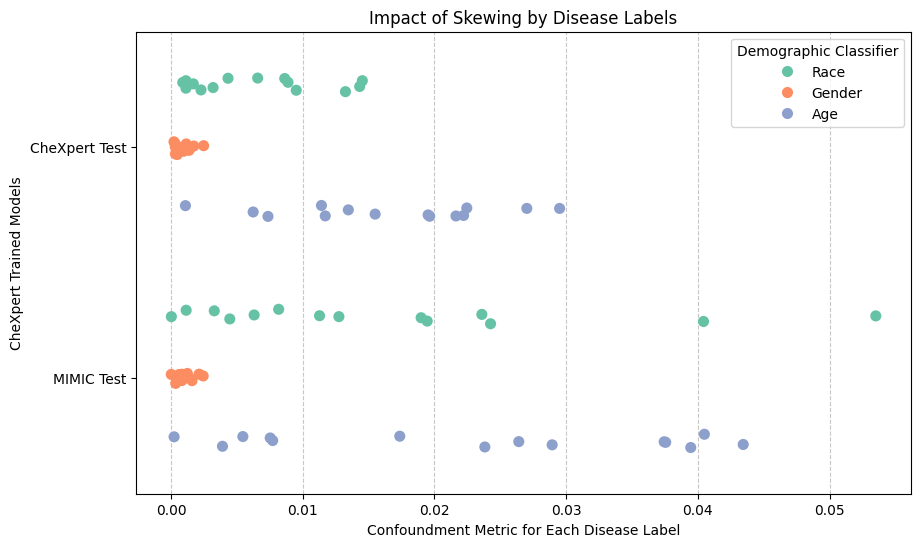

In [ ]:
data = {
    'Model': ['CheXpert Test'] * len(auc_chex_chex_race) + \
             ['MIMIC Test'] * len(auc_chex_mimic_race) + \
             ['CheXpert Test'] * len(auc_chex_chex_gender) + \
             ['MIMIC Test'] * len(auc_chex_mimic_gender) + \
             ['CheXpert Test'] * len(auc_chex_chex_age) + \
             ['MIMIC Test'] * len(auc_chex_mimic_age),

    'AUC': auc_chex_chex_race + auc_chex_mimic_race + \
           auc_chex_chex_gender + auc_chex_mimic_gender + \
           auc_chex_chex_age + auc_chex_mimic_age,

    'Category': ['Race'] * (len(auc_chex_chex_race) + len(auc_chex_mimic_race)) + \
                ['Gender'] * (len(auc_chex_chex_gender) + len(auc_chex_mimic_gender)) + \
                ['Age'] * (len(auc_chex_chex_age) + len(auc_chex_mimic_age))
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create scatter plot using Seaborn, hue to group by Category
plt.figure(figsize=(10, 6))
sns.stripplot(x='AUC', y='Model', hue='Category', data=df, jitter=True, palette='Set2', size=8, dodge=True)

# Adding labels and title
plt.title("Impact of Skewing by Disease Labels")
plt.xlabel("Confoundment Metric for Each Disease Label")
plt.ylabel("CheXpert Trained Models")

# Display the plot with grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.legend(title="Demographic Classifier")
plt.show()